# Joint optimization of PD and SD

This notebook explores the joint optimization of phase detection and stability detection.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from paretoset import paretoset
import pathlib
from dataclasses import dataclass
from typing import List, Dict
import itertools
import tqdm
import Mapper

import importlib
_ = importlib.reload(Mapper)

In [2]:
data_dir = pathlib.Path('/nethome/plavin3/sst/spec-utils/optimize/results/Jun-27/')

df_list = []
for i, filename in enumerate(data_dir.iterdir()):
    df_tmp = pd.read_csv(filename, delim_whitespace=True, comment='#')
    df_tmp['runid'] = i
    df_list.append(df_tmp)
df = pd.concat(df_list)

print(len(df))

518400


In [3]:
@dataclass(frozen=True)
class config:
    threshold: float
    phase_length: int
    stable_min: int
    window_start: int
    summarize: int
    proj_dist: int
    proj_delta: float
    p_j: int

# Get all the unique configs and package them in a class
def list_configs(df: pd.DataFrame) -> List[config]:
    tup_list = []
    for row in df[['threshold', 'phase_length', 'stable_min', 'window_start', 'summarize', 'proj_dist', 'proj_delta', 'p_j']].itertuples(index=False):
        tup_list.append(tuple(row))
    return [config(*t) for t in set(tup_list)]

def subset_config(df: pd.DataFrame, con: config) -> pd.DataFrame:
    return df[(df['threshold']    == con.threshold)    &
              (df['phase_length'] == con.phase_length) &
              (df['stable_min']   == con.stable_min)   &
              (df['window_start'] == con.window_start) &
              (df['summarize']    == con.summarize)    &
              (df['proj_dist']    == con.proj_dist)    &
              (df['proj_delta']   == con.proj_delta)   &
              (df['p_j']          == con.p_j)]

def subset_configs(df: pd.DataFrame, con: List[config]) -> pd.DataFrame:
    df_list = [subset_config(df, c) for c in con]
    return pd.concat(df_list)

In [4]:
config_list = list_configs(df)

## Per-Benchmark Configurations

What is the best configuration for each benchmark?

In [101]:
def split_benchmarks(df: pd.DataFrame) -> Dict[str, Dict[str, pd.DataFrame]]:
    benchmarks = set(df['benchmark'])
    ret = {}
    for b in benchmarks:
        #print(f'BENCHMARK: {b}')
        df_b = df[(df['benchmark']==b)]
    
        # Only consider configs where pct > 0 for all 5 runs
        which = [all(subset_config(df_b, con)['pct'] > 0.0) for con in config_list]
        con_subset = list(itertools.compress(config_list, which))
        
        # If none satisfy this robustness constraint, continue
        if sum(which) == 0:
            ret[b] = {'all': None, 'grouped': None, 'pareto': None}
            continue

        # Choose only runs that use these configs
        df_b = subset_configs(df_b, con_subset)

        # Group by config, average remaining columns
        df_grouped = df_b.groupby(['threshold', 'phase_length', 'stable_min', 'window_start', 'summarize', 'proj_dist', 'proj_delta', 'p_j'])
        df_mean = df_grouped.mean()
        
        # Get the pareo optimal set
        mask = paretoset(df_mean[['pct', 'err']], sense=['max', 'min'])
        df_pareto = df_mean[mask]
    
        ret[b] = {'all': df_b, 'grouped': df_grouped, 'pareto': df_pareto}
    return ret

In [102]:
%%time
per_benchmark = split_benchmarks(df)

CPU times: user 5min 2s, sys: 100 ms, total: 5min 2s
Wall time: 5min 3s


# Best Configs

What is the best configuration for each benchmark? 

Best is defined as either:
1. The configuration with the highest pct with err < 2.0 if it exists or
2. The configuration with the lowest err otherwise

In [133]:
%%time
def get_best(df_grouped):
    if df_grouped is None:
        return None
    groups = dict(list(df_grouped))

    low_error_groups = []
    for g in groups:
        dd = groups[g]['err'].mean()
        if dd < 2.0:
            low_error_groups.append(g)
    
    if len(low_error_groups) == 0:
        return None

    best = 0
    best_config = None
    for g in low_error_groups:
        ee = groups[g]['pct'].mean()
        if ee > best:
            best = ee
            best_config = g
    
    return g

best = {}
for bench in per_benchmark:
    best[bench] = get_best(per_benchmark[bench]['grouped'])
    
print(best.values())

dict_values([(0.65, 10000, 3, 50, 1000, 5, 2.0, 4), (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), (0.65, 50000, 3, 20, 1000, 15, 0.5, 6), None, None, None, None, (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), (0.65, 100000, 3, 75, 1500, 15, 2.0, 6), None, (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), (0.65, 100000, 3, 75, 1500, 15, 1.0, 10), None, (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), (0.5, 50000, 3, 75, 1500, 5, 2.0, 8), None, None, (0.65, 100000, 3, 75, 1500, 5, 2.0, 6), (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), None, (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), None, (0.6, 10000, 3, 50, 1500, 10, 1.0, 8), (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), None, (0.65, 10000, 3, 75, 1500, 15, 2.0, 4), (0.65, 100000, 3, 75, 1500, 5, 2.0, 6)])
CPU times: user 13.1 s, sys: 25 ms, total: 13.1 s
Wall time: 13.1 s


In [103]:
i = 0
for b in per_benchmark:
    if per_benchmark[b]['all'] is None:
        print(b)
        i += 1
print(f'Number of benchmarks with no robust configs: {i}')

gesummv
adi
trisolv
Number of benchmarks with no robust configs: 3


# Plot them

TypeError: type object argument after * must be an iterable, not NoneType

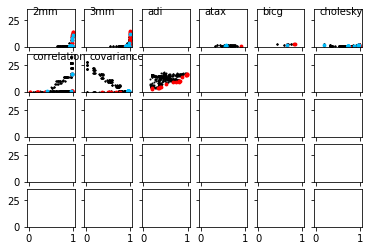

In [137]:
def reformat_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)

def innerplot(ax, **kwargs):
    #xs = np.float64(df2['pct'])
    #ys = np.float64(df2['acc'])
    #ax.scatter(xs, ys, s=4, c='red', label='Experiment 2')
    #print(kwargs['name'])
    if kwargs['data']['grouped'] is not None:
        xs = np.float64(kwargs['data']['grouped'].mean()['pct'])
        ys = np.float64(kwargs['data']['grouped'].mean()['err'])
        ax.scatter(xs, ys, s=1, c='black')
    
        xs = np.float64(kwargs['data']['pareto']['pct'])
        ys = np.float64(kwargs['data']['pareto']['err'])
        ax.scatter(xs, ys, s=8, c='red')
    
    best_pct = []
    best_err = []
    bpct = None
    berr = None
    if kwargs['best'] is not None and kwargs['data']['grouped'] is not None:
        for con in kwargs['best'].values():
            if con is not None:
                sc = subset_config(kwargs['data']['all'], config(*con))
                best_pct.append(sc.mean()['pct'])
                best_err.append(sc.mean()['err'])
        if kwargs['name'] in kwargs['best']:
            sc = subset_config(kwargs['data']['all'], config(*kwargs['best'][kwargs['name']]))
            bpct = sc.mean()['pct']
            perr = sc.mean()['err']

        ax.scatter(best_pct, best_err, s=8, c='deepskyblue')
        if bpct is not None:
            ax.scatter(bpct, berr, s=8, c='mediumspringgreen')
    
    # Style
    ax.text(0.08, 30, kwargs['name'], ha='left')
    ax.set_ylim((0,35))
    
    #reformat_ax(ax)

    
def outerplot(per_benchmark, **kwargs):
    
    ax_map = Mapper.Mapper(len(per_benchmark), sharex=True)
    fig = ax_map.fig
    benchmarks = set(df['benchmark'])
    
    ## Let's find the 'best' point for each benchmark, and plot all of those on each. 
    #for bench in benchmarks:
    #    pareto = per_benchmark[bench]['pareto']
    #    pareto
    
    for ax, bench in zip(ax_map, sorted(benchmarks)):
        #if per_benchmark[bench]['all'] is not None:
        innerplot(ax, name=bench, data=per_benchmark[bench], best=best)
        
    fig.set_size_inches(16,12)
    
outerplot(per_benchmark)

# Best Configs

What is the best configuration for each benchmark? 

Best is defined as either:
1. The configuration with the highest pct with err < 2.0 if it exists or
2. The configuration with the lowest err otherwise

In [115]:

    
print(best)

{'bicg': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'syr2k': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'correlation': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'seidel-2d': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'gemver': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'gesummv': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'durbin': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'cholesky': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'doitgen': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'gemm': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'adi': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), '3mm': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'heat-3d': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'floyd-warshall': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'trmm': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'mvt': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'trisolv': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'syrk': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'jacobi-1d': (0.65, 100000, 3, 75, 1500, 15, 2.0, 10), 'cov

## Robustness

Which parameters produce robust results with a higher probability?

In [51]:
params = ['threshold', 'phase_length', 'stable_min', 'window_start', 'summarize', 'proj_dist', 'proj_delta', 'p_j']

In [76]:
for par in params:
    vals = set(df[par])
    print(vals)

for bench in per_benchmark:
    if per_benchmark[bench]['all'] is not None:
        
        #print(per_benchmark[bench]['all'].obj['stable_min'])
        #break
        #print(len(list_configs(per_benchmark[bench]['all']['stable_min'])))

{0.5, 0.65, 0.6}
{10000, 50000, 100000}
{3}
{25, 50, 75, 20}
{1000, 1500}
{10, 5, 15}
{0.25, 1.0, 2.0, 0.5}
{8, 10, 4, 6}



1. Let's look at what values are the same:

    - `threshold`: Both take the maximum value of 0.6, indicating that a lower tolerace for determining similarity is alright
    - `window_start`: Both use the maximum value of 20, indicating that a larger window is good for accuracy but also find for time spent swapped.
    - `summarize`: Both use the maximum value of 1000


2. Now, where do they differ:

    - Remaining parameters for SD, `proj_dist`, `proj_delta`, `p_j`:
        - To get good accuracy, we need low tolerances for these. The high accuracy projects out further, requires tighter tolerances, and does more projection tests. However, this run is only swapped for about 50% of the time. **Question 1: if we just look at runs swapped over 80% of the time, how close can we get to an error of only 0.87?**
        
    - Remaining PD parameters, `phase_length`, `stable_min`:
        - Higher accuracy prefers a longer `phase_length`, but a smaller number of similar intervals required for stability (`stable_min`). 
        - **Question 2: How important are these? If we restrict ourselves to just the PD parameters used for high swap percentage, how close do we get to this accuracy goal?**

## Q1: If we just look at runs swapped over N% of the time, how close can we get to the minimum error of 0.871201?

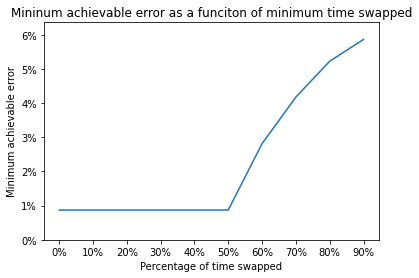

In [57]:
nx = 10

# Range is [min_pct, max_pct)
def pct_range(df, min_pct):
    return df[(df['pct'] >= min_pct)]

at_least = [(i/nx) for i in range(nx)]
min_err = []
for a in at_least:
    df_subset = pct_range(df, a)
    min_err.append(min(df_subset['acc']))

fig, ax = plt.subplots()
ax.plot(at_least, min_err)
ax.set_ylim(0, max(min_err)+0.5)
ax.set_xticks(at_least)
ax.set_xticklabels([f'{100*a:.0f}%' for a in at_least])
ax.set_yticks([int(i) for i in range(0,int(max(min_err))+2)])
ax.set_yticklabels([f'{int(i)}%' for i in range(0,int(max(min_err))+2)])
ax.set_xlabel('Percentage of time swapped')
ax.set_ylabel('Minimum achievable error')
ax.set_title('Mininum achievable error as a funciton of minimum time swapped')
plt.show()

What have we learned? From the parameters we have tried so far, the only way to get good accuracy is with a very low (~50%) amount of time spent swapped. We of course expected this relationship, but we need to see how far we can push the accuracy while keeping a relatively high swap percentage, say 80%.

## Question 2a: How important are `phase_length` and `stable_min`? If we restrict ourselves to just the PD parameters used for high swap percentage, how close do we get to this accuracy goal?

In [70]:
df_subset = df[(df['phase_length']==10_000) & (df['stable_min']==4)]
min_err_subset = min(df_subset['acc'])
res = float(df_subset[df_subset['acc'] == min_err_subset]['acc'])
print(f'Min error while using best phase_length and stable_min for high swap: {res:.3f}')

Min error while using best phase_length and stable_min for high swap: 1.511


## Question 2b: How important are `phase_length` and `stable_min`? If we restrict ourselves to just the *SD* parameters used for *low error*, how close do we get to this swap goal?

In [69]:
df_subset = df[(df['phase_length']==50_000) & (df['stable_min']==3)]
max_pct_subset = max(df_subset['pct'])
res = float(df_subset[df_subset['pct'] == max_pct_subset]['pct'])
print(f'Max percentage swapped while using best phase_length and stable_min for low error: {res:.3f}')

Max percentage swapped while using best phase_length and stable_min: 0.879


So we see that if we restrict ourselves to the best parameters for swap percentage, we can still achieve an accuracy of 1.5 (best was ~0.87), and if we restrict ourselves to the best parameters for low error, we can still achieve a swap percentage of 0.87 (best was ~0.92). 

This is somewhat heartening. Since we are more concerned with hitting a high accuracy, let's take the latter set of parameters for now.

## New Parameter Search

Now that we have learned a bit about the parameters, let's consider our next search space:

1. The parameters `threshold`, `window_start`, and `summarize` all maxed out their values. Let's add one larger value to all of those.

```
    threshold    = [0.6, 0.65]
    window_start = [20, 25]
    summarize    = [1000, 1500]
```

2. The parameters `phase_length` and `stable_min` were found to be relatively small, so we will restrict them for now.
```
    phase_length = [50_000]
    stable_min   = [3]
```

3. This leaves the three parameters we found to be very important for achieving high accuracy. Let's leave them alone for now.
```
    proj_dist  = [5, 10]
    proj_delta = [0.5, 1.0, 2.0]
    p_j        = [4, 6, 8, 10]
```

### Changes to scoring

Note that the scoring has changed slightly in this second set of data. Instead of a default score of (0,1), we now use a default of (0,0). A default score is used for traces with no RRs identified. The first number is the percent of time swapped, which of course is 0. The second number is the error, which I mistakenly set to be 1 before. The appropriate error for a trace with no RR is 0. This should not change the scoring very much.

In [130]:
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-normal-2.out') as file:
    df2 = pd.read_csv(file, sep=' ', comment='#')
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-normal-3.out') as file:
    df3 = pd.read_csv(file, sep=' ', comment='#')
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-normal-4.out') as file:
    df4 = pd.read_csv(file, sep=' ', comment='#')

In [73]:
# Highest swap percentage
df2[df2['pct'] == max(df2['pct'])]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
155,0.881869,5.96681,0.65,50000,3,20,1500,5,2.0,4


In [76]:
# Lowest Error
df2[df2['acc'] == min(df2['acc'])]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
6,0.417965,0.244749,0.60,50000,3,25,1500,10,0.5,10
7,0.417965,0.244749,0.65,50000,3,25,1500,10,0.5,10


Well, we managed to get even better error by running the models even less...

Let's look at some pareto style plots. 

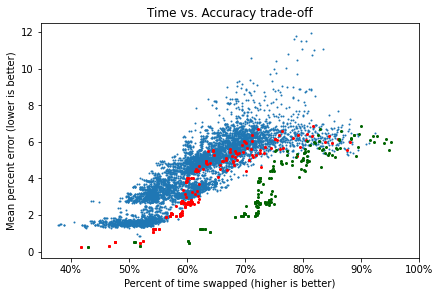

In [113]:
def pct_vs_err(ax, df, df2, df3, df4=None):
    xs = np.float64(df['pct'])
    ys = np.float64(df['acc'])
    ax.scatter(xs, ys, s=1, label='Experiment 1')
    
    xs = np.float64(df2['pct'])
    ys = np.float64(df2['acc'])
    ax.scatter(xs, ys, s=4, c='red', label='Experiment 2')
    
    xs = np.float64(df3['pct'])
    ys = np.float64(df3['acc'])
    ax.scatter(xs, ys, s=4, c='darkgreen', label='Experiment 3')
    
    if (df4 is not None):
        xs = np.float64(df4['pct'])
        ys = np.float64(df4['acc'])
        ax.scatter(xs, ys, s=4, c='lightgreen', label='Ex3 Pareto')
        
    nx = 10
    ax.set_xticks([i/nx for i in range(4, nx+1)])
    ax.set_xticklabels([f'{100*i/nx:.0f}%' for i in range(4, nx+1)])
    ax.set_xlabel('Percent of time swapped (higher is better)')
    
    ax.set_ylabel('Mean percent error (lower is better)')
    ax.set_title('Time vs. Accuracy trade-off')
    
fig, ax = plt.subplots(constrained_layout=True)
pct_vs_err(ax, df, df2, df3)
plt.show()

The next step is to modify the opitimizer to weight the `pct` value by the length of the various traces. Let's see how that changes the results of the second experiment. (See green values above)

Ok, so we've got more data. Should we re-run the analysis from before?

Let's calculate the pareo optimal values.

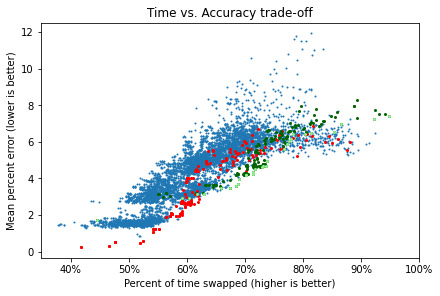

In [131]:
df_last = df4

mask = paretoset(df_last[['pct', 'acc']], sense=['max', 'min'])
fig, ax = plt.subplots(constrained_layout=True)
pct_vs_err(ax, df, df2, df_last, df_last[mask])
plt.show()

In [135]:
df_tmp = df_last[mask]

df_tmp[df_tmp['pct'] > .75]

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
19,0.775742,6.05822,0.65,50000,3,25,1500,10,1.0,4
53,0.773365,5.88368,0.65,50000,3,20,1000,10,2.0,6
61,0.866270,6.98569,0.65,50000,3,25,1500,5,2.0,6
66,0.779697,6.16297,0.65,50000,3,25,1500,10,2.0,6
69,0.766687,5.61596,0.60,50000,3,20,1000,10,2.0,6
76,0.852816,6.53936,0.60,50000,3,25,1500,5,2.0,6
104,0.803910,6.43417,0.60,50000,3,20,1500,5,1.0,4
109,0.782291,6.40880,0.65,50000,3,25,1500,5,2.0,8
155,0.813563,6.47726,0.60,50000,3,25,1000,10,2.0,4
163,0.922403,7.21995,0.60,50000,3,20,1500,5,2.0,4


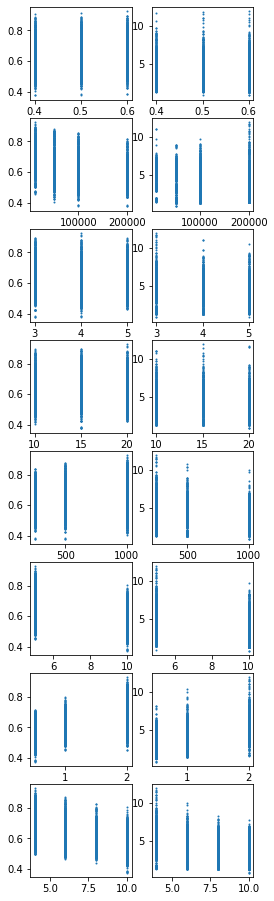

In [129]:
## Question: Do any parameter values always produce a result with percent error greater than X%? 

## Question: Do any parameter values always produce a result with time swapped less than Y%?

def plot_param(ax, df, x_param, y_param):
    ax.scatter(df[x_param], df[y_param], s=1)
    
fig, ax = plt.subplots(nrows=8, ncols=2)

y_params = ['pct', 'acc']
x_params = ['threshold', 'phase_length', 'stable_min', 'window_start', 'summarize', 'proj_dist', 'proj_delta', 'p_j']

for i, y_p in enumerate(y_params):
    for j, x_p in enumerate(x_params):
        plot_param(ax[j][i], df, x_p, y_p)
#plot_param(ax[0][0], df2, 'window_start', 'pct')
#plot_param(ax[0][0], df2, 'window_start', 'pct')

fig.set_size_inches((4, 16))

Ok, it's a bit hard to read that. 

Do we need to search more, or should we pick some parameters and re-run all the simulations? 

Do we need to evaluate on the full dataset? We could try that. 

# Version 2

In [199]:
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-subset-nanofix.out') as file:
    dfs = pd.read_csv(file, sep=' ', comment='#')

In [275]:
def do_ticks(ax, nx):
    ax.set_xticks([i/nx for i in range(0, nx+1)])
    tick_labels = []
    tick_labels.append('0%\n(1x)')
    for i in range(1, nx):
        tick_labels.append(f'{100*i/nx:.0f}%\n({1/(1-(i/nx)):.1f}x)')
    tick_labels.append('100%\n(∞x)')
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Percent of time post RR identification\n(Potential speedup)')
    
def pct_vs_err2(ax, df, **kwargs):
    xs = np.float64(df['pct'])
    ys = np.float64(df['acc'])
    ax.scatter(xs, ys, s=1, label='Experiment 1')
    nconfigs = len(xs)

    mask = paretoset(df[['pct', 'acc']], sense=['max', 'min'])
    xs = np.float64(df[mask]['pct'])
    ys = np.float64(df[mask]['acc'])
    ax.scatter(xs, ys, s=60, label='Pareto Ex. 1', c='red', marker='+')
    
    # Original value
    # 0.697184 4.81026
    #ax.scatter([0.697184], [4.81026], s=60, label='Original config', c='darkorange', marker='+')
    ax.scatter([0.544606], [1.78465], s=60, label='4-only config', c='darkorange', marker='+')
    
    do_ticks(ax, 10)
    
    ax.set_ylabel('Mean percent error')
    
    if ('title' in kwargs):
        ax.set_title(kwargs['title'])
    else:
        ax.set_title(f'{nconfigs} configurations')
    
    return mask
 

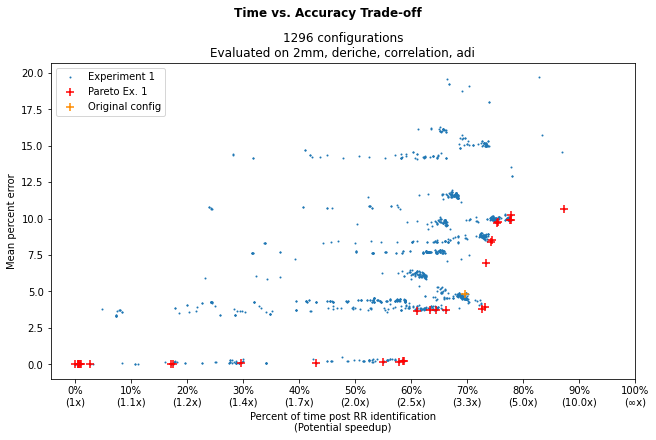

In [262]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches((6*1.5, 4*1.5))
pareto = pct_vs_err2(ax, dfs, title='1296 configurations\nEvaluated on 2mm, deriche, correlation, adi')
plt.legend()
plt.suptitle('Time vs. Accuracy Trade-off', weight='semibold')
plt.savefig('plots/time-vs-accuracy-trade-off.png')
plt.show()

In [198]:
dfs[pareto].sort_values('acc')

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
159,0.000000,0.000000,0.65,10000,3,50,1000,10,0.5,10
440,0.005024,0.001582,0.50,100000,3,20,1500,10,0.5,10
807,0.005757,0.001757,0.50,50000,3,20,1500,10,0.5,10
677,0.006252,0.003547,0.50,10000,3,50,1500,10,0.5,10
616,0.008713,0.007729,0.50,10000,3,50,1500,10,0.5,8
147,0.010445,0.018371,0.50,10000,3,25,1500,10,0.5,10
645,0.025919,0.019689,0.60,50000,3,50,1000,10,0.5,8
365,0.170941,0.021045,0.60,100000,3,50,1500,10,0.5,10
153,0.175800,0.028602,0.50,100000,3,50,1500,10,0.5,8
369,0.296591,0.072307,0.50,10000,3,25,1500,10,1.0,10


In [225]:
dfs[pareto][dfs[pareto]['acc']<1].sort_values('pct')

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
159,0.000000,0.000000,0.65,10000,3,50,1000,10,0.5,10
440,0.005024,0.001582,0.50,100000,3,20,1500,10,0.5,10
807,0.005757,0.001757,0.50,50000,3,20,1500,10,0.5,10
677,0.006252,0.003547,0.50,10000,3,50,1500,10,0.5,10
616,0.008713,0.007729,0.50,10000,3,50,1500,10,0.5,8
147,0.010445,0.018371,0.50,10000,3,25,1500,10,0.5,10
645,0.025919,0.019689,0.60,50000,3,50,1000,10,0.5,8
365,0.170941,0.021045,0.60,100000,3,50,1500,10,0.5,10
153,0.175800,0.028602,0.50,100000,3,50,1500,10,0.5,8
369,0.296591,0.072307,0.50,10000,3,25,1500,10,1.0,10


In [223]:
# Did any parameters only produce 'acc' values greater than 5? 
# Did any parameters only product 'pct' values lower than 0.5?

# Step 1: Get list of unique values for each parameter.

params_list = set(dfs.columns) - set(['acc', 'pct'])

for p in params_list:
    for u in set(dfs[p]):
    # check condition that subsetted df + acc cond has length > 0
        #print(f'[{p} = {u}] and [acc < 5]', len(dfs[(dfs[p]==u) & (dfs['acc'] < 5)]))
        #print(f'[{p} = {u}] and [pct > 0.5]', len(dfs[(dfs[p]==u) & (dfs['pct'] > 0.5)]))
        print(f'[{p} = {u}] and [acc < 5] and [pct > 0.5]', len(dfs[(dfs[p]==u) & (dfs['acc'] < 5) & (dfs['pct'] > 0.5)]))


[proj_dist = 10] and [acc < 5] and [pct > 0.5] 143
[proj_dist = 5] and [acc < 5] and [pct > 0.5] 194
[stable_min = 3] and [acc < 5] and [pct > 0.5] 337
[threshold = 0.6] and [acc < 5] and [pct > 0.5] 41
[threshold = 0.65] and [acc < 5] and [pct > 0.5] 48
[threshold = 0.5] and [acc < 5] and [pct > 0.5] 248
[p_j = 8] and [acc < 5] and [pct > 0.5] 78
[p_j = 10] and [acc < 5] and [pct > 0.5] 77
[p_j = 4] and [acc < 5] and [pct > 0.5] 102
[p_j = 6] and [acc < 5] and [pct > 0.5] 80
[window_start = 25] and [acc < 5] and [pct > 0.5] 127
[window_start = 50] and [acc < 5] and [pct > 0.5] 95
[window_start = 20] and [acc < 5] and [pct > 0.5] 115
[summarize = 1000] and [acc < 5] and [pct > 0.5] 165
[summarize = 1500] and [acc < 5] and [pct > 0.5] 172
[phase_length = 50000] and [acc < 5] and [pct > 0.5] 122
[phase_length = 10000] and [acc < 5] and [pct > 0.5] 94
[phase_length = 100000] and [acc < 5] and [pct > 0.5] 121
[proj_delta = 0.5] and [acc < 5] and [pct > 0.5] 110
[proj_delta = 1.0] and [acc 

In [227]:
TRACES

NameError: name 'TRACES' is not defined

In [254]:
with open('/nethome/plavin3/sst/spec-utils/optimize/results/opt-poly-jun14.out') as file:
    df_full = pd.read_csv(file, sep=' ', comment='#')

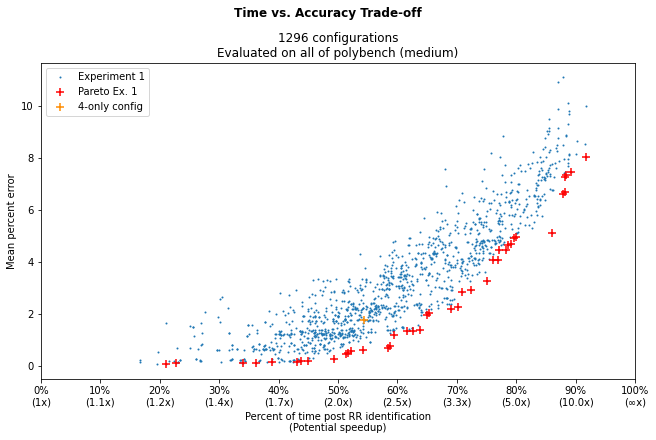

In [276]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches((6*1.5, 4*1.5))
pareto_full = pct_vs_err2(ax, df_full, title='1296 configurations\nEvaluated on all of polybench (medium)')
plt.legend()
plt.suptitle('Time vs. Accuracy Trade-off', weight='semibold')
#plt.savefig('plots/time-vs-accuracy-trade-off.png')
plt.show()

In [274]:
df_full[pareto_full][df_full[pareto_full]['acc']<1].sort_values('pct', ascending=False)

,pct,acc,threshold,phase_length,stable_min,window_start,summarize,proj_dist,proj_delta,p_j
938,0.587365,0.770067,0.5,50000,3,50,1500,10,2.0,8
985,0.584994,0.709931,0.5,50000,3,50,1500,10,2.0,10
1044,0.542752,0.610363,0.5,100000,3,50,1500,5,1.0,8
1101,0.521598,0.572646,0.5,100000,3,50,1500,5,1.0,10
137,0.517452,0.497921,0.5,50000,3,50,1500,5,1.0,8
180,0.512726,0.475512,0.5,50000,3,50,1500,5,1.0,10
437,0.492795,0.281160,0.5,50000,3,50,1500,10,0.5,4
760,0.449701,0.211161,0.5,100000,3,50,1500,5,0.5,8
894,0.438599,0.195913,0.5,100000,3,50,1000,10,0.5,6
828,0.430850,0.162458,0.5,100000,3,50,1500,5,0.5,10
